<a href="https://colab.research.google.com/github/aldojda/BigData/blob/main/Tarea_6_Modelo_de_Clasificaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn import set_config
from joblib import Parallel, delayed


# Fraudes en AirBnB: Caso de estudio

In [ ]:
# Fraudes en AirBnB: Caso de estudio
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls "drive/MyDrive"

 00-Personal/                       2923266427_protegido.pdf
'01 - Maestría Ciencia de Datos'/  'Colab Notebooks'/
 02-Profesional/                    npsfebrero_2702.csv
 05-Libros/                         npsjulio_clean.csv
 06-Proyectos/


In [ ]:
path = "drive/MyDrive/01 - Maestría Ciencia de Datos/Datos Masivos/Tarea 2/dataset_airbnb.csv"
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_rate         3585 non-null   int64  
 1   host_identity_verified     3585 non-null   int64  
 2   host_total_listings_count  3585 non-null   int64  
 3   city                       3585 non-null   int64  
 4   is_location_exact          3585 non-null   int64  
 5   property_type              3585 non-null   int64  
 6   room_type                  3585 non-null   int64  
 7   accommodates               3585 non-null   int64  
 8   bathrooms                  3585 non-null   float64
 9   bedrooms                   3585 non-null   float64
 10  beds                       3585 non-null   float64
 11  bed_type                   3585 non-null   int64  
 12  amenities                  3585 non-null   int64  
 13  price                      3585 non-null   int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = "fraud"), df["fraud"], test_size=0.2, random_state=42)

numeric_cols = X_train.select_dtypes(include=['float64', 'int64', "int"]).columns.to_list()

numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols)],
                                 remainder='passthrough')

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [ ]:
### neural network
model_1 =MLPClassifier(
            random_state = 0
            ).fit(X = X_train_prep, y = y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
### predictions
pred = model_1.predict(X = X_test_prep)

In [ ]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true = y_test,
        y_pred = pred
    )
)

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       561
           1       0.69      0.60      0.64       156

    accuracy                           0.85       717
   macro avg       0.79      0.76      0.77       717
weighted avg       0.85      0.85      0.85       717



In [ ]:
from sklearn.metrics import fbeta_score, f1_score, make_scorer, roc_auc_score
ftwo_scorer = make_scorer(fbeta_score, beta=2)
f_scorer = make_scorer(f1_score)
roc_auc_scorer = make_scorer(roc_auc_score)

# Hyperparameters
param_distributions = {
  'hidden_layer_sizes':[(100),(20,6),(32,5)],
  'activation':['tanh', 'relu'],
  'solver':['sgd'],
  'learning_rate':['adaptive','constant'],
  'learning_rate_init':[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
  'max_iter': [10000]
}

### random cross validation
grid = RandomizedSearchCV(
        estimator  = model_1,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = roc_auc_scorer, #f_scorer, # ftwo_scorer
        cv         = 10,
        verbose    = 0,
        random_state = 0,
        return_train_score = True,
        n_jobs = -1
       )

grid.fit(X = X_train_prep, y = y_train)

RandomizedSearchCV(cv=10, estimator=MLPClassifier(random_state=0), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'hidden_layer_sizes': [100, (20, 6),
                                                               (32, 5)],
                                        'learning_rate': ['adaptive',
                                                          'constant'],
                                        'learning_rate_init': [1e-06, 1e-05,
                                                               0.0001, 0.001,
                                                               0.01, 0.1],
                                        'max_iter': [10000],
                                        'solver': ['sgd']},
                   random_state=0, return_train_score=True,
                   scoring=make_scorer(roc_auc_score))

In [ ]:
###grid results
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head()

,param_solver,param_max_iter,param_learning_rate_init,param_learning_rate,param_hidden_layer_sizes,param_activation,mean_test_score,std_test_score,mean_train_score,std_train_score
14,sgd,10000,0.001,constant,"(32, 5)",tanh,0.731760,0.018683,0.744258,0.004533
1,sgd,10000,0.001,adaptive,"(32, 5)",tanh,0.731538,0.018885,0.744829,0.004842
32,sgd,10000,0.001,constant,"(20, 6)",relu,0.724974,0.018554,0.744920,0.005047
5,sgd,10000,0.001,adaptive,"(20, 6)",relu,0.724974,0.018554,0.745186,0.004538
42,sgd,10000,0.001,adaptive,"(20, 6)",tanh,0.722716,0.015565,0.736250,0.004769


In [ ]:
final_model = grid.best_estimator_

In [ ]:
### predictions
pred = final_model.predict(X = X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true = y_test,
        y_pred = pred
    )
)

              precision    recall  f1-score   support

           0       0.78      0.99      0.88       561
           1       0.00      0.00      0.00       156

    accuracy                           0.78       717
   macro avg       0.39      0.50      0.44       717
weighted avg       0.61      0.78      0.68       717



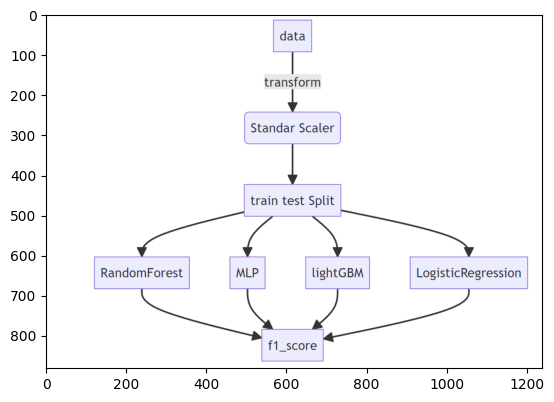

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as image
file = "drive/MyDrive/01 - Maestría Ciencia de Datos/Datos Masivos/Tarea 2/DiagramaProceso_BD.png"
process = image.imread(file)
plt.imshow(process)